# ✍ Semi-supervised Learning의 개념

#### ✔ 적은 labeled data가 있으면서 추가로 활용할 수 있는 대용량의 unlabeled data가 있을 때 사용한다. 


#### ✔ 소량의 labeled data에는 supervised learning을 적용하고 unlabeled data에는 unsupervised learning을 적용해 성능향상을 목표로 한다. 


#### ✔ 데이터 자체의 본질적인 특성이 모델링 된다면 소량의 labeled data를 통한 약간의 가이드로 일반화 성능을 끌어올릴 수 있다. 

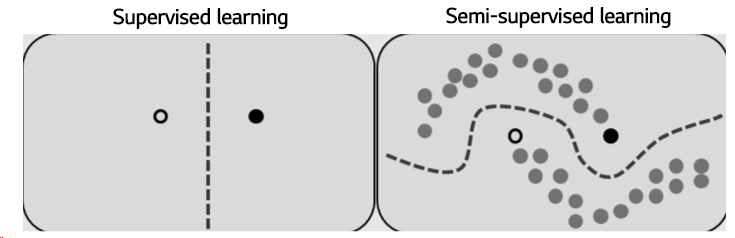

https://sanghyu.tistory.com/177

- Unlabeled data는 Unsupervised loss를 주어 데이터의 특성에 대해 학습하게 됨. 


- 여기서 Unlabeled data에 주는 Unsupervised task를 어떻게 정할 것이냐에 따라 방법론이 나뉘게 됨.

---

# 1️⃣ Proxy-label method 

- Labeled set으로 학습된 모델을 이용해 unlabeled data point들에 label을 달아주는 기법


- 만약 Labeled set의 분포를 벗어나는 샘플들에는 제대로 된 label을 달아주기 어렵기 때문에 성능향상에 한계가 있다는 단점이 있음. 


- 그래도 Labeled set 분포 내의 샘플들에 대해 interpolation하는 효과가 있기때문에 아직도 많이 사용되는 기법임. 


## 📌 Method 1. Pseudo Label (13')

### 0. 라이브러리 및 파라미터 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

import argparse, math, time, json, os

from lib import wrn, transform, datasets, train_and_test
from config import config

import warnings
warnings.filterwarnings( 'ignore' )

# cuda 연결
if torch.cuda.is_available():
    device = "cuda"
    torch.backends.cudnn.benchmark = True
else:
    device = "cpu"

In [2]:
# Jensen-shannon divergence(JSD) 
class JSD(nn.Module):
    
    def __init__(self):
        super(JSD, self).__init__()
    
    def forward(self, net_1_logits, net_2_logits):
        net_1_probs =  F.softmax(net_1_logits, dim=1)
        net_2_probs=  F.softmax(net_2_logits, dim=1)

        total_m  = 0.5 * (net_1_probs + net_1_probs)
        loss = 0.0
        loss += F.kl_div(F.log_softmax(net_1_logits, dim=1), total_m, reduction="none") 
        loss += F.kl_div(F.log_softmax(net_2_logits, dim=1), total_m, reduction="none") 
     
        return (0.5 * loss)
    
jsd_loss = JSD()

In [3]:
# 공통 parameter
shared_cfg = {
    "iteration" : 5000,
    "warmup" : 200000,
    "lr_decay_iter" : 400000,
    "lr_decay_factor" : 0.2,
    "batch_size" : 100,
}

In [ ]:
### 모델/데이터별로 변경 ###

In [15]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="PL", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [17]:
# dataset 관련 parameter
'''svhn'''
dataset_cfg = {'transform': [False, True, False],
 'dataset': datasets.svhn.SVHN,
 'num_classes': 10}

In [18]:
# algorithm 관련 parameter
'''PL: pseudo label'''
alg_cfg = {
    "threashold" : 0.95,
    "lr" : 3e-4,
    "consis_coef" : 1,
}

In [ ]:
##############################

### 1. Data 

In [19]:
# 사용하는 dataset transform 기법
transform_fn = transform.transform(*dataset_cfg["transform"])

# (l/un)train-valid-test dataset
l_train_dataset = dataset_cfg["dataset"](args.root, "l_train") # labeled train dataset 
u_train_dataset = dataset_cfg["dataset"](args.root, "u_train") # unlabeled train dataset
val_dataset = dataset_cfg["dataset"](args.root, "val") # valid dataset
test_dataset = dataset_cfg["dataset"](args.root, "test") # test dataset
print("labeled data : {}, unlabeled data : {}, training data : {}".format(
    len(l_train_dataset), len(u_train_dataset), len(l_train_dataset)+len(u_train_dataset)))
print("validation data : {}, test data : {}".format(len(val_dataset), len(test_dataset)))

holizontal flip : False, random crop : True, gaussian noise : False
labeled data : 1000, unlabeled data : 64931, training data : 65931
validation data : 7326, test data : 26032


In [20]:
class RandomSampler(torch.utils.data.Sampler):
    """ sampling without replacement """
    def __init__(self, num_data, num_sample):
        iterations = num_sample // num_data + 1
        self.indices = torch.cat([torch.randperm(num_data) for _ in range(iterations)]).tolist()[:num_sample]

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [21]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : PL
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
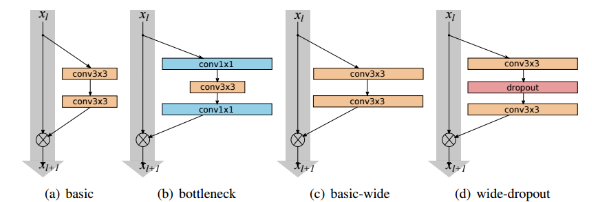
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `Pseudo Label`
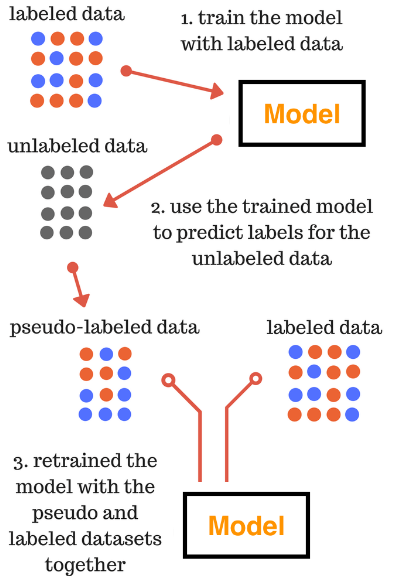
https://sanghyu.tistory.com/177

In [22]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


In [24]:
'''Pseudo Label(Semi-Supervised)'''
class PL(nn.Module):
    def __init__(self, threshold):
        super().__init__()
        self.th = threshold

    def forward(self, x, y, model, mask):
        y_probs = y.softmax(1)
        onehot_label = self.__make_one_hot(y_probs.max(1)[1]).float()
        gt_mask = (y_probs > self.th).float()
        gt_mask = gt_mask.max(1)[0] # reduce_any
        lt_mask = 1 - gt_mask # logical not
        p_target = gt_mask[:,None] * 10 * onehot_label + lt_mask[:,None] * y_probs
        model.update_batch_stats(False)
        output = model(x)
        loss = (-(p_target.detach() * F.log_softmax(output, 1)).sum(1)*mask).mean()
        model.update_batch_stats(True)
        return loss

    def __make_one_hot(self, y, n_classes=10):
        return torch.eye(n_classes)[y].to(y.device)
    
# Semi-Supervised model
ssl_obj = PL(alg_cfg["threashold"]) 

### 3. Train and test

In [27]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 1.025641e-01, SSL loss : 3.915986e-03, coef : 8.62470e-03, time : 16.662 iter/sec, rest : 0.000 min, lr : 0.0003 
### validation ###
[50/58] time : 106.6 data/sec, rest : 0.08 sec 
varidation accuracy : 0.7134861946105957
### test ###
[200/204] time : 919.9 data/sec, rest : 0.00 sec  
test accuracy : 0.7161570191383362
test acc : 0.7161570191383362


---

# 2️⃣ Consistency regularization

- 이 방법은 unlabeled data point에 작은 perturbation을 주어도 예측의 결과에는 일관성이 있을 거라고 가정함. 


- unlabeled data는 예측결과를 알 수 없기 때문에 data augmentation을 통해 class가 바뀌지 않을 정도의 변화를 줬을 때, 원 데이터와의 예측결과가 같아지도록 unsupervised loss를 주어 학습하게 됨. 


- 이를 통해 약간 헷갈리는 샘플들에 대해 class를 유연하게 예측할 수 있도록 해줌. 


- 성능이 좋은 semi-supervised learning 모델들은 대체로 consistency regularization을 사용하고 있음. 


- 단, 이미지 분야는 많은 연구들을 통해 class가 바뀌지 않을 정도의 data augmentation 기법들이 많이 연구되었지만 그 외의 도메인에서는 도메인 지식없이는 제대로 된 data augmentation을 적용하기 어려워 적용에 한계가 있음. 

## 📌 Method 2. PI model (16')

### 0. 라이브러리 및 파라미터 설정

In [ ]:
### 모델/데이터별로 변경 ###

In [29]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="PI", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [30]:
# algorithm 관련 parameter
'''PI: Pi Model'''
alg_cfg = {
    "lr" : 3e-4,
    "consis_coef" : 20.0,
}

In [ ]:
##############################

### 1. Data 

In [31]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : PI
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
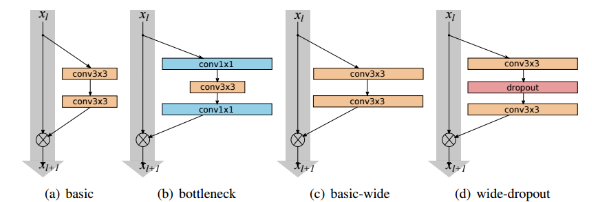
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `PiModel`
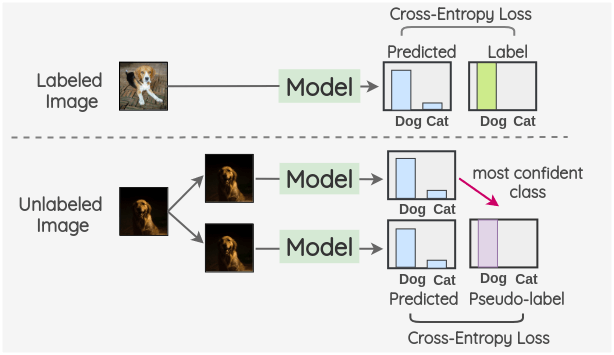
https://amitness.com/2020/07/semi-supervised-learning/

In [32]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


<All keys matched successfully>

In [33]:
'''Pi Model(Semi-Supervised)'''
class PiModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y, model, mask):
        # NOTE:
        # stochastic transformation is embeded in forward function
        # so, pi-model is just to calculate consistency between two outputs
        model.update_batch_stats(False)
        y_hat = model(x)
        model.update_batch_stats(True)
        return (F.mse_loss(y_hat.softmax(1), y.softmax(1).detach(), reduction="none").mean(1) * mask).mean()
    
    
# Semi-Supervised model
ssl_obj = PiModel()

### 3. Train and test

In [34]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 3.552396e-04, SSL loss : 6.372844e-04, coef : 1.72494e-01, time : 16.974 iter/sec, rest : 0.000 min, lr : 0.0003 
### validation ###
[50/58] time : 103.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.7897897958755493
### test ###
[200/204] time : 1033.7 data/sec, rest : 0.00 sec 
test accuracy : 0.785610020160675
test acc : 0.785610020160675


In [35]:
# Loss 함수 변경 1
'''L1 Loss'''
class PiModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y, model, mask):
        model.update_batch_stats(False)
        y_hat = model(x)
        model.update_batch_stats(True)
        return (F.l1_loss(y_hat.softmax(1), y.softmax(1).detach(), reduction="none").mean(1) * mask).mean()
    

ssl_obj = PiModel()
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 1.395757e-04, SSL loss : 9.524687e-04, coef : 1.72494e-01, time : 16.944 iter/sec, rest : 0.000 min, lr : 0.0003 
### validation ###
[50/58] time : 105.5 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8326508402824402
### test ###
[200/204] time : 1055.4 data/sec, rest : 0.00 sec 
test accuracy : 0.8381606936454773
test acc : 0.8381606936454773


In [36]:
# Loss 함수 변경 2
'''KL_div'''
class PiModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y, model, mask):
        model.update_batch_stats(False)
        y_hat = model(x)
        model.update_batch_stats(True)
        return (F.kl_div(y_hat.softmax(1), y.softmax(1).detach(), reduction="none").mean(1) * mask).mean()
    

ssl_obj = PiModel()
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 6.024397e-05, SSL loss : -8.936448e-03, coef : 1.72494e-01, time : 16.854 iter/sec, rest : 0.000 min, lr : 0.0003 
### validation ###
[50/58] time : 104.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8478023409843445
### test ###
[200/204] time : 1044.5 data/sec, rest : 0.00 sec 
test accuracy : 0.8576751351356506
test acc : 0.8576751351356506


In [39]:
# Loss 함수 변경 3
'''JS_div'''
class PiModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y, model, mask):
        model.update_batch_stats(False)
        y_hat = model(x)
        model.update_batch_stats(True)
        return (jsd_loss.forward(y_hat.softmax(1), y.softmax(1).detach()).mean(1) * mask).mean()
    

ssl_obj = PiModel()
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 1.190877e-01, SSL loss : 2.612777e-05, coef : 1.72494e-01, time : 16.914 iter/sec, rest : 0.000 min, lr : 0.0003 
### validation ###
[50/58] time : 104.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.639366626739502
### test ###
[200/204] time : 1044.2 data/sec, rest : 0.00 sec 
test accuracy : 0.6418254375457764
test acc : 0.6418254375457764


---

## 📌 Method 3. VAT(17')

### 0. 라이브러리 및 파라미터 설정

In [84]:
### 모델/데이터별로 변경 ###

In [85]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="VAT", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [86]:
# algorithm 관련 parameter
'''VAT: virtual adversarial training'''
alg_cfg = {
    "xi" : 1e-6,
    "eps" : {"cifar10":6, "svhn":1},
    "consis_coef" : 0.3,
    "lr" : 3e-3
}

In [87]:
##############################

### 1. Data 

In [88]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : VAT
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
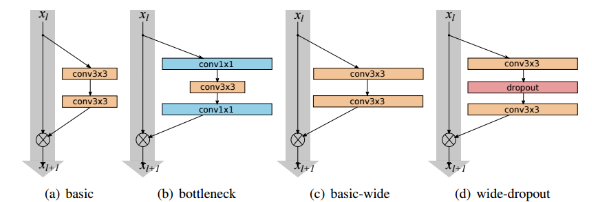
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `VAT`
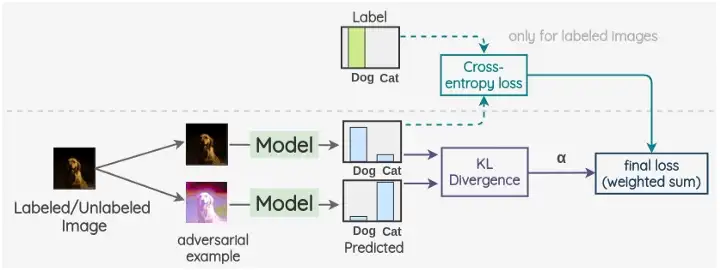
https://sh-tsang.medium.com/review-virtual-adversarial-training-vat-4b3d8b7b2e92

In [89]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


<All keys matched successfully>

In [90]:
'''VAT Model(Semi-Supervised)'''
class VAT(nn.Module):
    def __init__(self, eps=1.0, xi=1e-6, n_iteration=1):
        super().__init__()
        self.eps = eps
        self.xi = xi
        self.n_iteration = n_iteration

    def kld(self, q_logit, p_logit):
        q = q_logit.softmax(1)
        qlogp = (q * self.__logsoftmax(p_logit)).sum(1)
        qlogq = (q * self.__logsoftmax(q_logit)).sum(1)
        return qlogq - qlogp

    def normalize(self, v):
        v = v / (1e-12 + self.__reduce_max(v.abs(), range(1, len(v.shape))))
        v = v / (1e-6 + v.pow(2).sum((1,2,3),keepdim=True)).sqrt()
        return v

    def forward(self, x, y, model, mask):
        model.update_batch_stats(False)
        d = torch.randn_like(x)
        d = self.normalize(d)
        for _ in range(self.n_iteration):
            d.requires_grad = True
            x_hat = x + self.xi * d
            y_hat = model(x_hat)
            kld = self.kld(y.detach(), y_hat).mean()
            d = torch.autograd.grad(kld, d)[0]
            d = self.normalize(d).detach()
        x_hat = x + self.eps * d
        y_hat = model(x_hat)
        # NOTE:
        # Original implimentation of VAT defines KL(P(y|x)||P(x|x+r_adv)) as loss function
        # However, Avital Oliver's implimentation use KL(P(y|x+r_adv)||P(y|x)) as loss function of VAT
        # see issue https://github.com/brain-research/realistic-ssl-evaluation/issues/27
        loss = (self.kld(y_hat, y.detach()) * mask).mean()
        model.update_batch_stats(True)
        return loss

    def __reduce_max(self, v, idx_list):
        for i in idx_list:
            v = v.max(i, keepdim=True)[0]
        return v

    def __logsoftmax(self,x):
        xdev = x - x.max(1, keepdim=True)[0]
        lsm = xdev - xdev.exp().sum(1, keepdim=True).log()
        return lsm
    
    
# Semi-Supervised model
ssl_obj = VAT(alg_cfg["eps"][args.dataset], alg_cfg["xi"], 1)

### 3. Train and test

In [91]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 6.274493e-05, SSL loss : 1.070692e-03, coef : 2.58741e-03, time : 10.324 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 90.3 data/sec, rest : 0.09 sec 
varidation accuracy : 0.8670488595962524
### test ###
[200/204] time : 828.7 data/sec, rest : 0.00 sec 
test accuracy : 0.880378007888794
test acc : 0.880378007888794


---

## 📌 Method 4. Mean Teacher (17')

### 0. 라이브러리 및 파라미터 설정

In [42]:
### 모델/데이터별로 변경 ###

In [50]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="MT", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [51]:
# algorithm 관련 parameter
'''MT: mean teacher'''
alg_cfg = {
    "ema_factor" : 0.95,
    "lr" : 4e-4,
    "consis_coef" : 8,
}

In [ ]:
##############################

### 1. Data 

In [52]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : MT
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
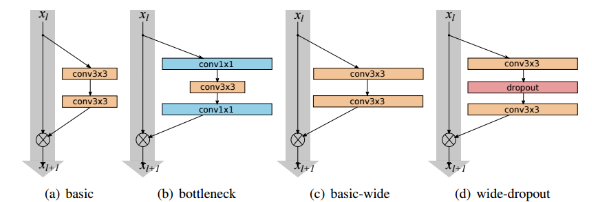
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `Mean Teacher`

- 기존 모델인 temporal ensembling 모델은 결과의 EMA를 계산하기 위해 매 epoch마다 결과를 integrate해주어야 함. 


- 하지만 이러한 방법은 epoch마다 1번의 연산을 수행하기 때문에 integrate 속도가 매우 느림. 


- 따라서 `mean teacher`는 과거 학습의 '결과'의 EMA를 사용하는 것이 아닌, 'parameter'의 EMA를 사용한다는 차이점이 있음. 


- Student 모델은 자체적으로 모델을 학습하는 반면, teacher model은 student 모델의 parameter의 EMA를 parameter로 사용함. 


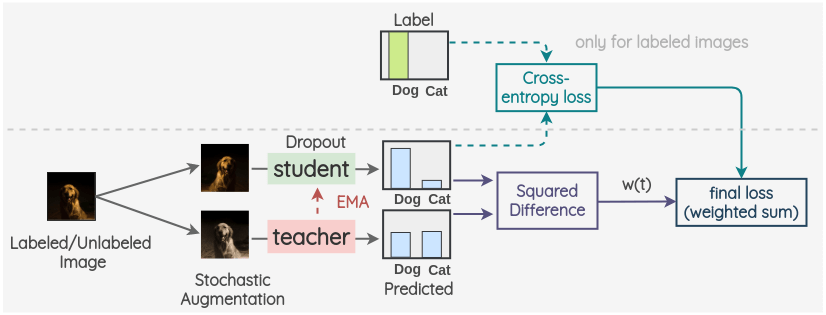
https://velog.io/@injokim/%EC%99%95%EC%B4%88%EA%B8%89-Semi-supervised-learning-%EC%9E%85%EB%AC%B8

In [47]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


<All keys matched successfully>

In [53]:
'''MT (Mean Teacher)'''
class MT(nn.Module):
    def __init__(self, model, ema_factor):
        super().__init__()
        self.model = model
        self.model.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1
        y_hat = self.model(x)
        model.update_batch_stats(False)
        y = model(x) # recompute y since y as input of forward function is detached
        model.update_batch_stats(True)
        return (F.mse_loss(y.softmax(1), y_hat.softmax(1).detach(), reduction="none").mean(1) * mask).mean()

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step+1), self.ema_factor)
        for emp_p, p in zip(self.model.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data

    
# Semi-Supervised model
ssl_obj = MT(t_model, alg_cfg["ema_factor"])

### 3. Train and test

In [54]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 3.480127e-05, SSL loss : 1.939247e-04, coef : 6.89976e-02, time : 14.636 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 103.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8568113446235657
### test ###
[200/204] time : 1023.1 data/sec, rest : 0.00 sec 
test accuracy : 0.8700445294380188
test acc : 0.8700445294380188


In [55]:
# Loss 함수 변경 1
'''L1 Loss'''
class MT(nn.Module):
    def __init__(self, model, ema_factor):
        super().__init__()
        self.model = model
        self.model.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1
        y_hat = self.model(x)
        model.update_batch_stats(False)
        y = model(x) # recompute y since y as input of forward function is detached
        model.update_batch_stats(True)
        return (F.l1_loss(y.softmax(1), y_hat.softmax(1).detach(), reduction="none").mean(1) * mask).mean()

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step+1), self.ema_factor)
        for emp_p, p in zip(self.model.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data


ssl_obj = MT(t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 2.510125e-05, SSL loss : 8.575320e-04, coef : 6.89976e-02, time : 14.864 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 103.3 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8629538416862488
### test ###
[200/204] time : 1033.7 data/sec, rest : 0.00 sec 
test accuracy : 0.8748078942298889
test acc : 0.8748078942298889


In [56]:
# Loss 함수 변경 2
'''KL_div'''
class MT(nn.Module):
    def __init__(self, model, ema_factor):
        super().__init__()
        self.model = model
        self.model.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1
        y_hat = self.model(x)
        model.update_batch_stats(False)
        y = model(x) # recompute y since y as input of forward function is detached
        model.update_batch_stats(True)
        return (F.kl_div(y.softmax(1), y_hat.softmax(1).detach(), reduction="none").mean(1) * mask).mean()

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step+1), self.ema_factor)
        for emp_p, p in zip(self.model.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data
    

ssl_obj = MT(t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 1.609678e-05, SSL loss : -3.495436e-03, coef : 6.89976e-02, time : 14.740 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 105.5 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8628173470497131
### test ###
[200/204] time : 1044.5 data/sec, rest : 0.00 sec 
test accuracy : 0.8667793273925781
test acc : 0.8667793273925781


In [57]:
# Loss 함수 변경 3
'''JS_div'''
class MT(nn.Module):
    def __init__(self, model, ema_factor):
        super().__init__()
        self.model = model
        self.model.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1
        y_hat = self.model(x)
        model.update_batch_stats(False)
        y = model(x) # recompute y since y as input of forward function is detached
        model.update_batch_stats(True)
        return (jsd_loss.forward(y.softmax(1), y_hat.softmax(1).detach()).mean(1) * mask).mean()

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step+1), self.ema_factor)
        for emp_p, p in zip(self.model.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data
            
ssl_obj = MT(t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 3.288622e-03, SSL loss : 1.675125e-05, coef : 6.89976e-02, time : 14.767 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 103.3 data/sec, rest : 0.08 sec 
varidation accuracy : 0.846164345741272
### test ###
[200/204] time : 1044.5 data/sec, rest : 0.00 sec 
test accuracy : 0.8467270731925964
test acc : 0.8467270731925964


---

## 📌 Method 5. ICT (19')

### 0. 라이브러리 및 파라미터 설정

In [59]:
### 모델/데이터별로 변경 ###

In [60]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="ICT", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [61]:
# algorithm 관련 parameter
'''ICT: interpolation consistency training'''
alg_cfg = {
    "ema_factor" : 0.999,
    "lr" : 4e-4,
    "consis_coef" : 100,
    "alpha" : 0.1,
}

In [62]:
##############################

### 1. Data 

In [63]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : ICT
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
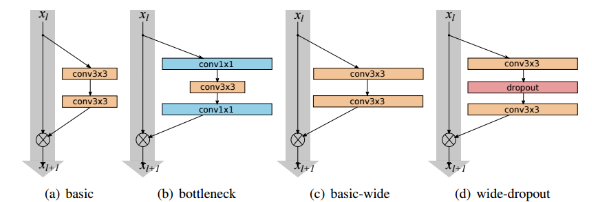
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `Interpolation Consistency Training`

- 두 개의 라벨이 없는 데이터로부터 interpolation을 생성하고, 두 개의 output이 consistent하도록 학습함. 


- Mixup 개념 활용함. 


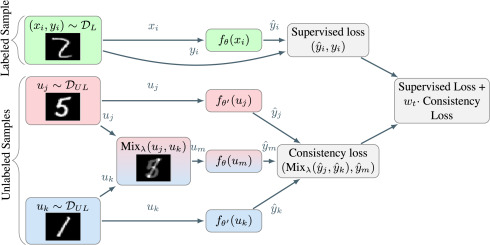
Verma, V., Kawaguchi, K., Lamb, A., Kannala, J., Bengio, Y., & Lopez-Paz, D. (2019). Interpolation consistency training for semi-supervised learning. arXiv preprint arXiv:1903.03825.

In [64]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


<All keys matched successfully>

In [65]:
'''ICT (Interpolation Consistency Training)'''
class ICT(nn.Module):
    def __init__(self, alpha, model, ema_factor):
        super().__init__()
        self.alpha = alpha
        self.mean_teacher = model
        self.mean_teacher.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        self.global_step += 1 # for moving average coef
        mask = mask.byte()
        model.update_batch_stats(False)
        mt_y = self.mean_teacher(x).detach()
        u_x, u_y = x[mask], mt_y[mask]
        l_x, l_y = x[mask==0], mt_y[mask==0]
        lam = np.random.beta(self.alpha, self.alpha) # sample mixup coef
        perm = torch.randperm(u_x.shape[0])
        perm_u_x, perm_u_y = u_x[perm], u_y[perm]
        mixed_u_x = lam * u_x + (1 - lam) * perm_u_x
        mixed_u_y = (lam * u_y + (1 - lam) * perm_u_y).detach()
        y_hat = model(torch.cat([l_x, mixed_u_x], 0)) # "cat" indicates to compute batch stats from full batches
        loss = F.mse_loss(y_hat.softmax(1), torch.cat([l_y, mixed_u_y], 0).softmax(1), reduction="none").sum(1)
        # compute loss for only unlabeled data, but loss is normalized by full batchsize
        loss = loss[l_x.shape[0]:].sum() / x.shape[0]
        model.update_batch_stats(True)
        return loss

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step), self.ema_factor)
        for emp_p, p in zip(self.mean_teacher.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data
            
            
    
# Semi-Supervised model
ssl_obj = MT(t_model, alg_cfg["ema_factor"])

### 3. Train and test

In [66]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 5.176672e-03, SSL loss : 2.265541e-02, coef : 8.62470e-01, time : 14.395 iter/sec, rest : 0.000 min, lr : 0.0004 
### validation ###
[50/58] time : 104.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.7364182472229004
### test ###
[200/204] time : 1012.8 data/sec, rest : 0.00 sec 
test accuracy : 0.7478103637695312
test acc : 0.7478103637695312


In [67]:
# Loss 함수 변경 1
'''L1 Loss'''
class ICT(nn.Module):
    def __init__(self, alpha, model, ema_factor):
        super().__init__()
        self.alpha = alpha
        self.mean_teacher = model
        self.mean_teacher.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        self.global_step += 1 # for moving average coef
        mask = mask.byte()
        model.update_batch_stats(False)
        mt_y = self.mean_teacher(x).detach()
        u_x, u_y = x[mask], mt_y[mask]
        l_x, l_y = x[mask==0], mt_y[mask==0]
        lam = np.random.beta(self.alpha, self.alpha) # sample mixup coef
        perm = torch.randperm(u_x.shape[0])
        perm_u_x, perm_u_y = u_x[perm], u_y[perm]
        mixed_u_x = lam * u_x + (1 - lam) * perm_u_x
        mixed_u_y = (lam * u_y + (1 - lam) * perm_u_y).detach()
        y_hat = model(torchssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"]).cat([l_x, mixed_u_x], 0)) # "cat" indicates to compute batch stats from full batches
        loss = F.l1_loss(y_hat.softmax(1), torch.cat([l_y, mixed_u_y], 0).softmax(1), reduction="none").sum(1)
        # compute loss for only unlabeled data, but loss is normalized by full batchsize
        loss = loss[l_x.shape[0]:].sum() / x.shape[0]
        model.update_batch_stats(True)
        return loss

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step), self.ema_factor)
        for emp_p, p in zip(self.mean_teacher.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data


ssl_obj = ICT(alg_cfg["alpha"], t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 2.989135e-04, SSL loss : 1.052538e-01, coef : 8.62470e-01, time : 14.584 iter/sec, rest : 0.000 min, lr : 0.0004 
### validation ###
[50/58] time : 102.3 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8525798320770264
### test ###
[200/204] time : 1055.5 data/sec, rest : 0.00 sec 
test accuracy : 0.875614583492279
test acc : 0.875614583492279


In [68]:
# Loss 함수 변경 2
'''KL_div'''
class ICT(nn.Module):
    def __init__(self, alpha, model, ema_factor):
        super().__init__()
        self.alpha = alpha
        self.mean_teacher = model
        self.mean_teacher.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        self.global_step += 1 # for moving average coef
        mask = mask.byte()
        model.update_batch_stats(False)
        mt_y = self.mean_teacher(x).detach()
        u_x, u_y = x[mask], mt_y[mask]
        l_x, l_y = x[mask==0], mt_y[mask==0]
        lam = np.random.beta(self.alpha, self.alpha) # sample mixup coef
        perm = torch.randperm(u_x.shape[0])
        perm_u_x, perm_u_y = u_x[perm], u_y[perm]
        mixed_u_x = lam * u_x + (1 - lam) * perm_u_x
        mixed_u_y = (lam * u_y + (1 - lam) * perm_u_y).detach()
        y_hat = model(torch.cat([l_x, mixed_u_x], 0)) # "cat" indicates to compute batch stats from full batches
        loss = F.kl_div(y_hat.softmax(1), torch.cat([l_y, mixed_u_y], 0).softmax(1), reduction="none").sum(1)
        # compute loss for only unlabeled data, but loss is normalized by full batchsize
        loss = loss[l_x.shape[0]:].sum() / x.shape[0]
        model.update_batch_stats(True)
        return loss

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step), self.ema_factor)
        for emp_p, p in zip(self.mean_teacher.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data

    

ssl_obj = ICT(alg_cfg["alpha"], t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 3.087756e-05, SSL loss : -4.274860e-01, coef : 8.62470e-01, time : 14.158 iter/sec, rest : 0.000 min, lr : 0.0004 
### validation ###
[50/58] time : 102.3 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8883429169654846
### test ###
[200/204] time : 1023.1 data/sec, rest : 0.00 sec 
test accuracy : 0.9066917300224304
test acc : 0.9066917300224304


In [70]:
# Loss 함수 변경 3
'''JS_div'''
class ICT(nn.Module):
    def __init__(self, alpha, model, ema_factor):
        super().__init__()
        self.alpha = alpha
        self.mean_teacher = model
        self.mean_teacher.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        self.global_step += 1 # for moving average coef
        mask = mask.byte()
        model.update_batch_stats(False)
        mt_y = self.mean_teacher(x).detach()
        u_x, u_y = x[mask], mt_y[mask]
        l_x, l_y = x[mask==0], mt_y[mask==0]
        lam = np.random.beta(self.alpha, self.alpha) # sample mixup coef
        perm = torch.randperm(u_x.shape[0])
        perm_u_x, perm_u_y = u_x[perm], u_y[perm]
        mixed_u_x = lam * u_x + (1 - lam) * perm_u_x
        mixed_u_y = (lam * u_y + (1 - lam) * perm_u_y).detach()
        y_hat = model(torch.cat([l_x, mixed_u_x], 0)) # "cat" indicates to compute batch stats from full batches
        loss = jsd_loss.forward(y_hat.softmax(1), torch.cat([l_y, mixed_u_y], 0).softmax(1)).sum(1)
        # compute loss for only unlabeled data, but loss is normalized by full batchsize
        loss = loss[l_x.shape[0]:].sum() / x.shape[0]
        model.update_batch_stats(True)
        return loss

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step), self.ema_factor)
        for emp_p, p in zip(self.mean_teacher.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data

            
ssl_obj = ICT(alg_cfg["alpha"], t_model, alg_cfg["ema_factor"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 4.855150e-06, SSL loss : 1.166972e-04, coef : 8.62470e-01, time : 14.564 iter/sec, rest : 0.000 min, lr : 0.0004 
### validation ###
[50/58] time : 104.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.8970788717269897
### test ###
[200/204] time : 1055.4 data/sec, rest : 0.00 sec 
test accuracy : 0.9133758544921875
test acc : 0.9133758544921875


---

# 3️⃣ Holistic methods

- 여러 semi-supervised learning 기법들을 통합하고 Mixup data augmentatino을 적용하여 성능을 더 끌어 올림.

## 📌 Method 6. MixMatch (19')

### 0. 라이브러리 및 파라미터 설정

In [71]:
### 모델/데이터별로 변경 ###

In [72]:
# Hyperparameter 설정
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="MM", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=25000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="svhn", type=str, help="dataset name : [svhn, cifar10]") 
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args, unknown = parser.parse_known_args() 

In [73]:
# algorithm 관련 parameter
'''MM: mixmatch'''
alg_cfg = {
    "lr" : 3e-3,
    "consis_coef" : 100,
    "alpha" : 0.75,
    "T" : 0.5,
    "K" : 2,
}

In [74]:
##############################

### 1. Data 

In [75]:
# Dataloader
'''labeled data'''
if args.alg != "supervised":
    # batch size = 0.5 x batch size
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
    )
else:
    l_loader = DataLoader(
        l_train_dataset, shared_cfg["batch_size"], drop_last=True,
        sampler=RandomSampler(len(l_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"])
    )
print("algorithm : {}".format(args.alg))

'''unlabeled data'''
u_loader = DataLoader(
    u_train_dataset, shared_cfg["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_cfg["iteration"] * shared_cfg["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

print("maximum iteration : {}".format(min(len(l_loader), len(u_loader))))

algorithm : MM
maximum iteration : 5000


### 2. Model

#### - Training Model: `WRN (Wide Residual Networks)`
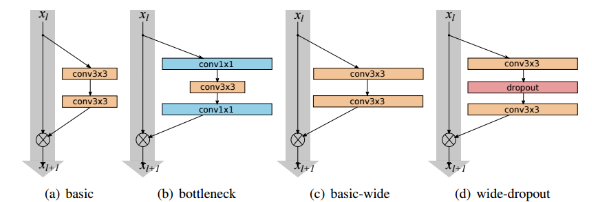
https://deep-learning-study.tistory.com/519

#### - Semi-Supervised Learning Model: `Mixmatch`

- Labeled data와 unlabeled data에 대해 Entropy Minimization을 적용하여 훈련시킴. 


- Unlabeled data의 경우, GT label이 없기 때문에 Pseudo labeling 기법을 사용함. 


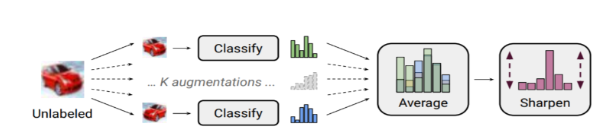

https://rain-bow.tistory.com/entry/Semi-Supervised-Learning-SSL-%EC%86%8C%EA%B0%9C-%EB%B0%8F-%EB%8F%99%ED%96%A5

In [76]:
'''Wide Residual Networks(Train)'''
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])
trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

# train model
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())

trainable parameters : 1467610


<All keys matched successfully>

In [77]:
'''MixMatch (Semi-Supervised)'''
class MixMatch(nn.Module):
    def __init__(self, temperature, n_augment, alpha):
        super().__init__()
        self.T = temperature
        self.K = n_augment
        self.beta_distirb = torch.distributions.beta.Beta(alpha, alpha)

    def sharpen(self, y):
        y = y.pow(1/self.T)
        return y / y.sum(1,keepdim=True)

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        model.update_batch_stats(False)
        u_x = x[mask == 1]
        # K augmentation and make prediction labels
        u_x_hat = [u_x for _ in range(self.K)]
        y_hat = sum([model(u_x_hat[i]).softmax(1) for i in range(len(u_x_hat))]) / self.K
        y_hat = self.sharpen(y_hat)
        y_hat = y_hat.repeat(len(u_x_hat), 1)
        # mixup
        u_x_hat = torch.cat(u_x_hat, 0)
        index = torch.randperm(u_x_hat.shape[0])
        shuffled_u_x_hat, shuffled_y_hat = u_x_hat[index], y_hat[index]
        lam = self.beta_distirb.sample().item()
        # lam = max(lam, 1-lam)
        mixed_x = lam * u_x_hat + (1-lam) * shuffled_u_x_hat
        mixed_y = lam * y_hat + (1-lam) * shuffled_y_hat.softmax(1)
        # mean squared error
        loss = F.mse_loss(model(mixed_x), mixed_y)
        model.update_batch_stats(True)
        return loss

    
    
# Semi-Supervised model
ssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"])

### 3. Train and test

In [78]:
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 6.892656e-04, SSL loss : 1.119236e-03, coef : 8.62470e-01, time : 10.395 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 96.4 data/sec, rest : 0.08 sec 
varidation accuracy : 0.6388206481933594
### test ###
[200/204] time : 1002.3 data/sec, rest : 0.00 sec 
test accuracy : 0.631338357925415
test acc : 0.631338357925415


In [79]:
# Loss 함수 변경 1
'''L1 Loss'''
class MixMatch(nn.Module):
    def __init__(self, temperature, n_augment, alpha):
        super().__init__()
        self.T = temperature
        self.K = n_augment
        self.beta_distirb = torch.distributions.beta.Beta(alpha, alpha)

    def sharpen(self, y):
        y = y.pow(1/self.T)
        return y / y.sum(1,keepdim=True)

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        model.update_batch_stats(False)
        u_x = x[mask == 1]
        # K augmentation and make prediction labels
        u_x_hat = [u_x for _ in range(self.K)]
        y_hat = sum([model(u_x_hat[i]).softmax(1) for i in range(len(u_x_hat))]) / self.K
        y_hat = self.sharpen(y_hat)
        y_hat = y_hat.repeat(len(u_x_hat), 1)
        # mixup
        u_x_hat = torch.cat(u_x_hat, 0)
        index = torch.randperm(u_x_hat.shape[0])
        shuffled_u_x_hat, shuffled_y_hat = u_x_hat[index], y_hat[index]
        lam = self.beta_distirb.sample().item()
        # lam = max(lam, 1-lam)
        mixed_x = lam * u_x_hat + (1-lam) * shuffled_u_x_hat
        mixed_y = lam * y_hat + (1-lam) * shuffled_y_hat.softmax(1)
        # mean squared error
        loss = F.l1_loss(model(mixed_x), mixed_y)
        model.update_batch_stats(True)
        return loss


ssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 1.436315e-04, SSL loss : 8.697409e-03, coef : 8.62470e-01, time : 10.414 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 99.8 data/sec, rest : 0.08 sec  
varidation accuracy : 0.6915097236633301
### test ###
[200/204] time : 961.3 data/sec, rest : 0.00 sec 
test accuracy : 0.6815841794013977
test acc : 0.6815841794013977


In [80]:
# Loss 함수 변경 2
'''KL_div'''
class MixMatch(nn.Module):
    def __init__(self, temperature, n_augment, alpha):
        super().__init__()
        self.T = temperature
        self.K = n_augment
        self.beta_distirb = torch.distributions.beta.Beta(alpha, alpha)

    def sharpen(self, y):
        y = y.pow(1/self.T)
        return y / y.sum(1,keepdim=True)

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        model.update_batch_stats(False)
        u_x = x[mask == 1]
        # K augmentation and make prediction labels
        u_x_hat = [u_x for _ in range(self.K)]
        y_hat = sum([model(u_x_hat[i]).softmax(1) for i in range(len(u_x_hat))]) / self.K
        y_hat = self.sharpen(y_hat)
        y_hat = y_hat.repeat(len(u_x_hat), 1)
        # mixup
        u_x_hat = torch.cat(u_x_hat, 0)
        index = torch.randperm(u_x_hat.shape[0])
        shuffled_u_x_hat, shuffled_y_hat = u_x_hat[index], y_hat[index]
        lam = self.beta_distirb.sample().item()
        # lam = max(lam, 1-lam)
        mixed_x = lam * u_x_hat + (1-lam) * shuffled_u_x_hat
        mixed_y = lam * y_hat + (1-lam) * shuffled_y_hat.softmax(1)
        # mean squared error
        loss = F.kl_div(model(mixed_x), mixed_y)
        model.update_batch_stats(True)
        return loss

    

ssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 3.131836e-01, SSL loss : -2.632174e+03, coef : 8.62470e-01, time : 10.358 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 95.5 data/sec, rest : 0.08 sec  
varidation accuracy : 0.5597870349884033
### test ###
[200/204] time : 963.6 data/sec, rest : 0.00 sec 
test accuracy : 0.5533574223518372
test acc : 0.5533574223518372


In [83]:
# Loss 함수 변경 3
'''JS_div'''
class MixMatch(nn.Module):
    def __init__(self, temperature, n_augment, alpha):
        super().__init__()
        self.T = temperature
        self.K = n_augment
        self.beta_distirb = torch.distributions.beta.Beta(alpha, alpha)

    def sharpen(self, y):
        y = y.pow(1/self.T)
        return y / y.sum(1,keepdim=True)

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        model.update_batch_stats(False)
        u_x = x[mask == 1]
        # K augmentation and make prediction labels
        u_x_hat = [u_x for _ in range(self.K)]
        y_hat = sum([model(u_x_hat[i]).softmax(1) for i in range(len(u_x_hat))]) / self.K
        y_hat = self.sharpen(y_hat)
        y_hat = y_hat.repeat(len(u_x_hat), 1)
        # mixup
        u_x_hat = torch.cat(u_x_hat, 0)
        index = torch.randperm(u_x_hat.shape[0])
        shuffled_u_x_hat, shuffled_y_hat = u_x_hat[index], y_hat[index]
        lam = self.beta_distirb.sample().item()
        # lam = max(lam, 1-lam)
        mixed_x = lam * u_x_hat + (1-lam) * shuffled_u_x_hat
        mixed_y = lam * y_hat + (1-lam) * shuffled_y_hat.softmax(1)
        # mean squared error
        loss = jsd_loss.forward(model(mixed_x), mixed_y).mean()
        model.update_batch_stats(True)
        return loss
            
ssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"])
train_and_test.Main(args, model, alg_cfg, shared_cfg, ssl_obj, optimizer, l_loader, u_loader, val_loader, val_dataset, test_loader, test_dataset)

iteration [5000/5000] cls loss : 0.000000e+00, SSL loss : 9.391984e-02, coef : 8.62470e-01, time : 9.845 iter/sec, rest : 0.000 min, lr : 0.003 
### validation ###
[50/58] time : 89.5 data/sec, rest : 0.09 sec 
varidation accuracy : 0.7282282114028931
### test ###
[200/204] time : 919.9 data/sec, rest : 0.00 sec 
test accuracy : 0.7337891459465027
test acc : 0.7337891459465027


참고문헌
https://github.com/perrying/realistic-ssl-evaluation-pytorch